<h1 style="background-image: url('https://images.pexels.com/photos/259200/pexels-photo-259200.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'); background-size: cover; color: #ffffff; padding: 30px;border-radius: 15px; text-align: center; font-family: 'JetBrains Mono', sans-serif; font-size: 4rem;">
    Bank Churn Analysis
</h1>

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1.2rem; color: #000000"><b>About This Notebook:</b></p>
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        This notebook focuses on performing exploratory data analysis, data pre-processing, and machine learning on bank churn data in order to produce a model that predicts whether a customer will leave a bank. The data source for this notebook is <a href="https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction/data?select=Churn_Modelling.csv" target="_blank">Bank Customer Churn Prediction</a> on Kaggle.
    </p>
</div>

In [32]:
### Imports
## Standard Library
# File Manipulation
import os

# Standard/Log Output Management
import warnings
warnings.filterwarnings("ignore")

## External Packages
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
import xgboost as xgb
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1.2rem; color: #000000"><b>Environment Set Up:</b></p>
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        In order to ensure a consistent environment, some helper functions have been created to ensure that the data file exists, and to load the data into a <code>DataFrame</code> with the appropriate parameters.
    </p>
</div>

In [33]:
### Helpers for Accessing Data
## Variables
# Files & Directories
DATA_DIRECTORY = os.path.join("..", "data")
DATA_FILE = os.path.join(DATA_DIRECTORY, "Churn_Modelling.csv")

## Functions
# Load Data into DataFrame
def load_data() -> pd.DataFrame:
    try:
        return pd.read_csv(filepath_or_buffer = DATA_FILE)
    except FileNotFoundError as error:
        print(f"{error.__class__.__name__}: '{DATA_FILE}' does not exist")

In [34]:
### Accessing the Data
## Loading the Data
# Saving In DataFrame Variable
df = load_data()

## Previewing Data
# Viewing the First 5 Rows
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1.2rem; color: #000000"><b>Exploratory Data Analysis (EDA):</b></p>
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        This section focuses on using EDA methods that are visual and text-based in order to identify what patterns may exist in the data, and to potentially aid in engineering additional features.
    </p>
</div>

In [103]:
### Helpers for Exploring Data
## Text-Based
# Metadata of DataFrame
def view_metadata(dataframe: pd.DataFrame) -> pd.DataFrame:
    metadata: list[dict[str, str | int]] = [
        {"property": "rows", "value": dataframe.shape[0]},
        {"property": "columns", "value": dataframe.shape[1]},
        {"property": "column_names", "value": ", ".join(dataframe.columns.to_list())},
        {"property": "data_types", "value": dataframe.dtypes.to_dict()},
        {"property": "nulls", "value": dataframe.isnull().sum().to_json()},
        {"property": "duplicates", "value": dataframe.duplicated().sum()},
    ]
    return pd.DataFrame(data = metadata)

# Summary Statistics
def view_summary_statistics(dataframe: pd.DataFrame) -> pd.DataFrame:
    return dataframe.describe()

## Graphics-Based
# Configuring Canvas Styles
def configure_canvas_styles() -> None:
    plt.style.use(style = "seaborn-v0_8-whitegrid")
    sns.set_theme(font_scale = 1)

# Plotting Distribution for Categorical & Discrete Columns
def plot_value_count_distribution(dataframe: pd.DataFrame, column_name: str) -> None:
    # Storing Value Counts for Target Column
    value_counts = dataframe[column_name].value_counts()

    # Defining Canvas Style
    configure_canvas_styles()

    # Creating Canvas for Plots
    figures, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))

    # Creating the Pie Chart
    axes[0].pie(
        x = value_counts,
        labels = value_counts.index,
        autopct = "%1.1f%%",
        colors = sns.color_palette(palette = "Set2"),
        shadow = True
    )
    axes[0].set_xlabel(column_name)

    # Creating the Bar Chart
    sns.countplot(
        data = dataframe,
        x = column_name,
        palette = "Set2",
        ax = axes[1]
    )

    # Defining Visualization Title
    plt.suptitle(t = f"Distribution of {column_name}", fontsize = 18, fontweight = "bold")

    # Displaying Canvas
    plt.show()

# Plotting Distribution for Continuous Columns
def plot_continuous_distribution(dataframe: pd.DataFrame, column_name: str, target_column: str) -> None:
    # Defining Canvas Style
    configure_canvas_styles()

    # Creating Canvas for Plot
    figure, axis = plt.subplots(figsize = (18, 6))

    # Creating the Histogram
    sns.histplot(
        data = dataframe,
        x = column_name,
        bins = 10,
        kde = True,
        palette = "Set2",
        hue = target_column,
    )

    # Defining Visualization Title
    plt.suptitle(t = f"Distribution of {column_name}", fontsize = 18, fontweight = "bold")

    # Displaying Canvas
    plt.show()

# Plotting Correlation Matrix
def plot_correlation_matrix(dataframe: pd.DataFrame, column_list: list[str]) -> None:
    # Creating Correlation Matrix
    correlation_matrix = dataframe[column_list].copy().corr()

    # Defining Canvas Style
    configure_canvas_styles()

    # Creating Mask for Plot
    symmetry_mask = np.zeros_like(a = correlation_matrix)
    symmetry_mask[np.triu_indices_from(arr = symmetry_mask)] = True

    # Creating Canvas for Plot
    figure, axis = plt.subplots(figsize = (16, 16))

    # Plotting Correlation Matrix As Heatmap
    sns.heatmap(
        data = correlation_matrix,
        mask = symmetry_mask,
        annot = True,
        fmt = ".3f",
        cmap = "summer"
    )

    # Defining Visualization Title
    plt.suptitle(t = "Correlation Matrix of Features & Target", fontsize = 18, fontweight = "bold")

    # Displaying Canvas
    plt.show()

In [36]:
### Text-Based Exploratory Data Analysis (Metadata)
view_metadata(dataframe = df)

,property,value
0,rows,10000
1,columns,14
2,column_names,"RowNumber, CustomerId, Surname, CreditScore, G..."
3,data_types,"{'RowNumber': int64, 'CustomerId': int64, 'Sur..."
4,nulls,"{""RowNumber"":0,""CustomerId"":0,""Surname"":0,""Cre..."
5,duplicates,0


<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        The above metadata shows that there are no null values or duplicate rows within the dataset. As such, data will not need to be imputed in order to make the dataset more complete.
    </p>
</div>

In [37]:
### Text-Based Exploratory Data Analysis (Summary Statistics)
view_summary_statistics(dataframe = df)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


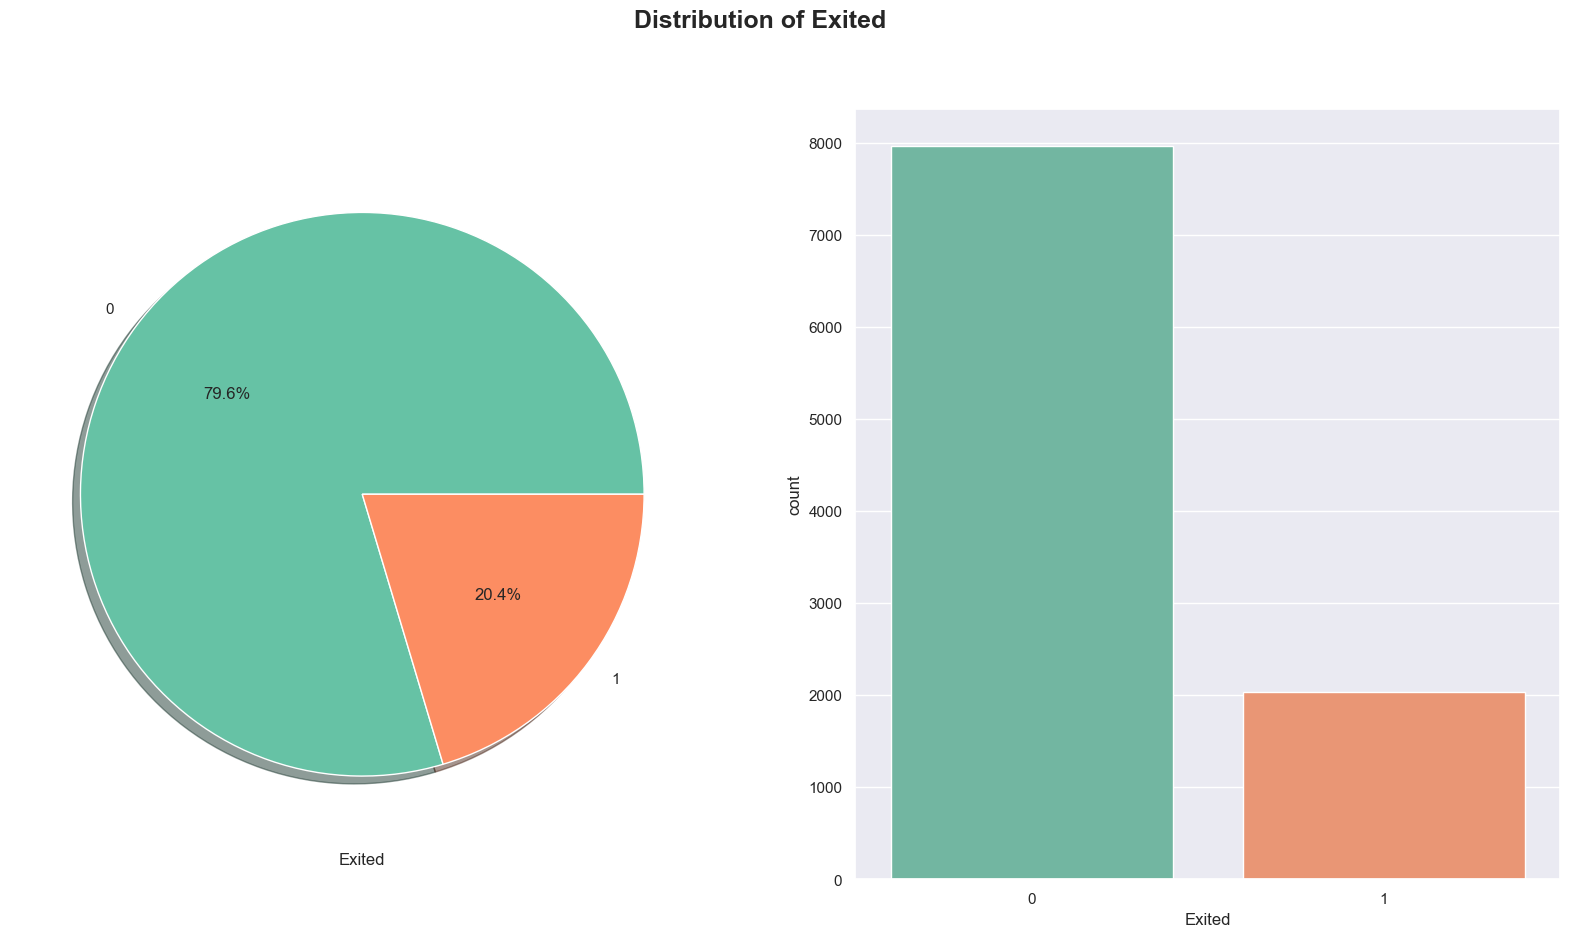

In [104]:
### Graphical Exploratory Data Analysis (Target Distribution)
plot_value_count_distribution(dataframe = df, column_name = "Exited")

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        The above plots indicate that the data is significantly skewed, with <b>80%</b> of customers not exiting the bank. To address this disparity, some sampling techniques could be applied to balance out the dataset when training the model.
    </p>
</div>

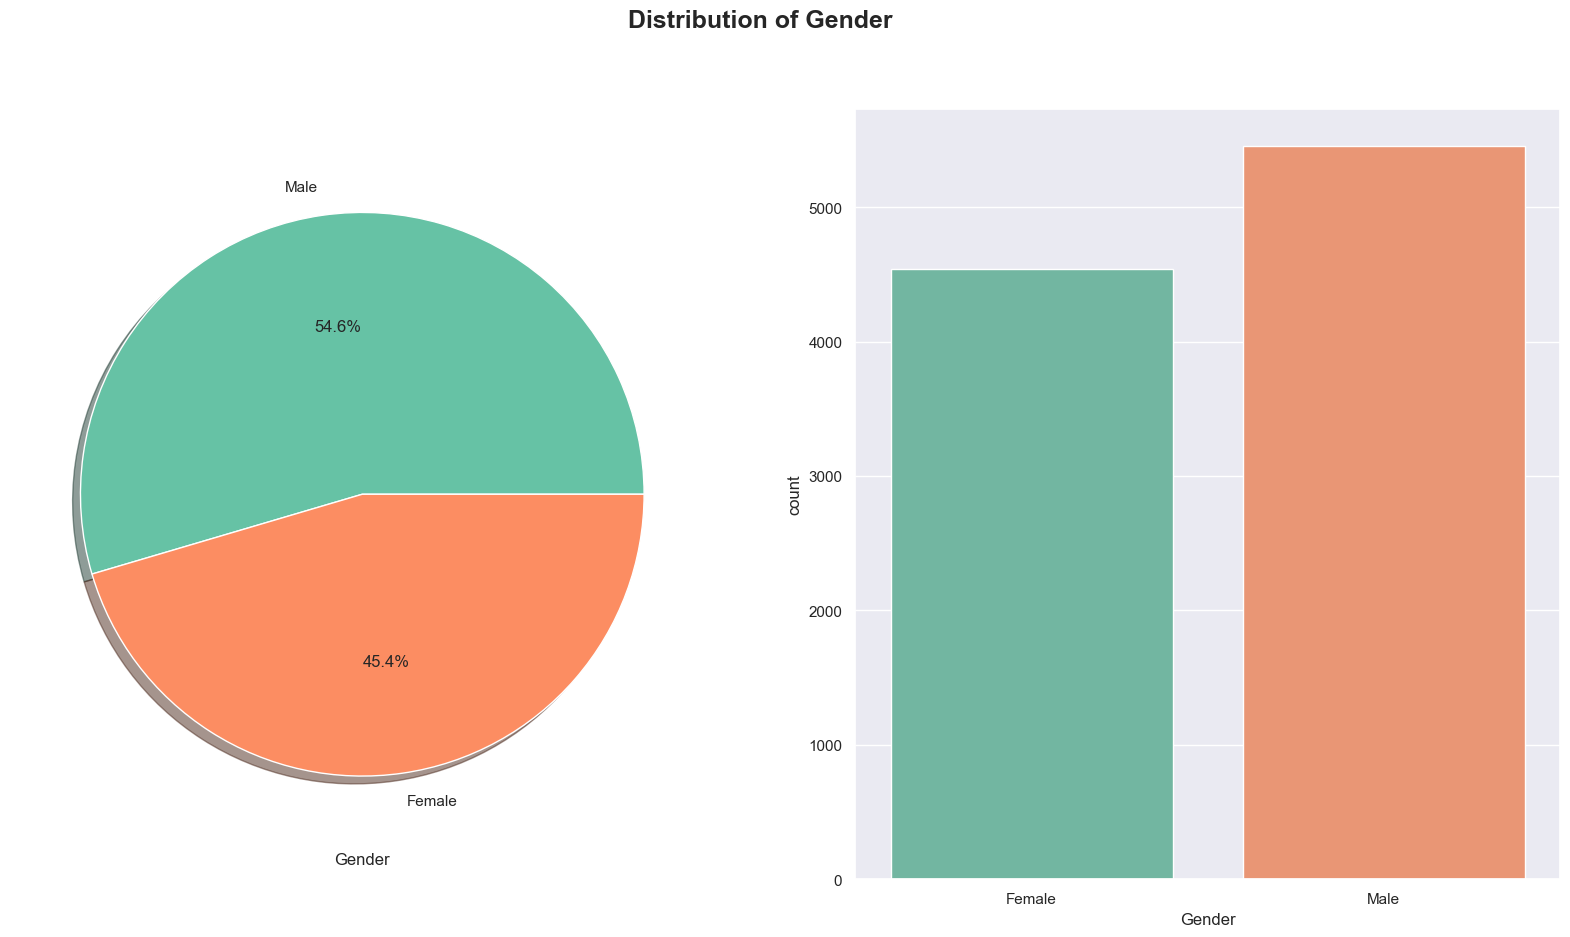

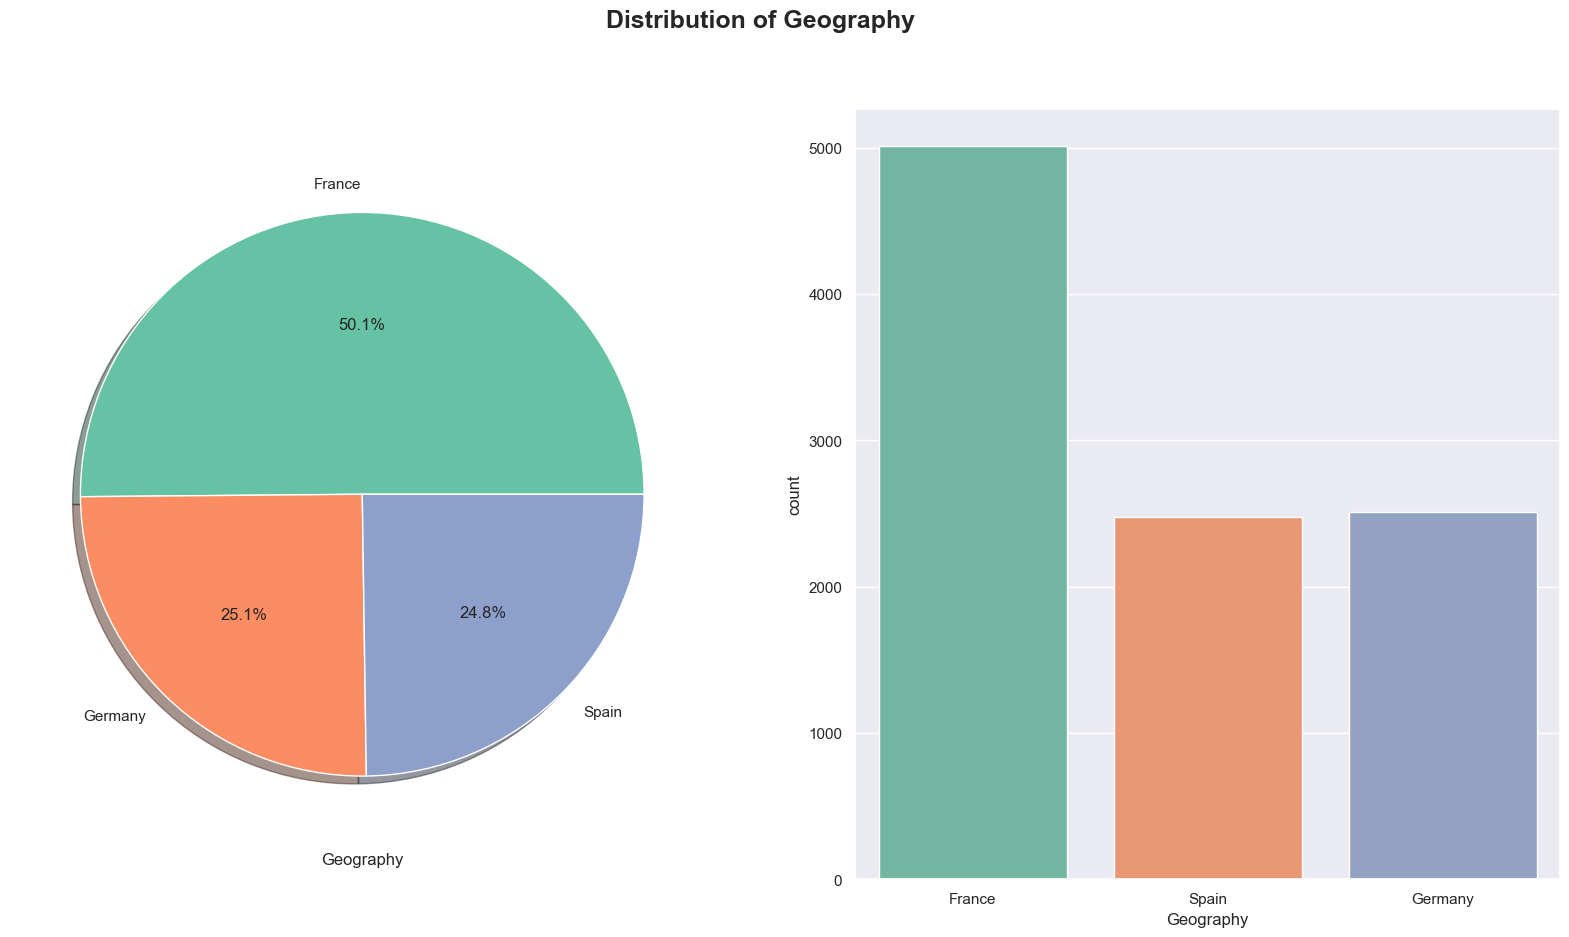

In [39]:
### Graphical Exploratory Data Analysis (Categorical Feature Distributions)
column_names = ["Gender", "Geography"]
for column_name in column_names:
        plot_value_count_distribution(dataframe = df, column_name = column_name)

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        When it comes to the distribution of <code>Gender</code> within the dataset, the difference is not too large compared to the target variable. However, the same cannot be said for the <code>Geography</code> feature, as there are more customers from France than Spain or Germany individually. As with the target variable, sampling techniques could be applied here to balance out the distribution if necessary.
    </p>
</div>

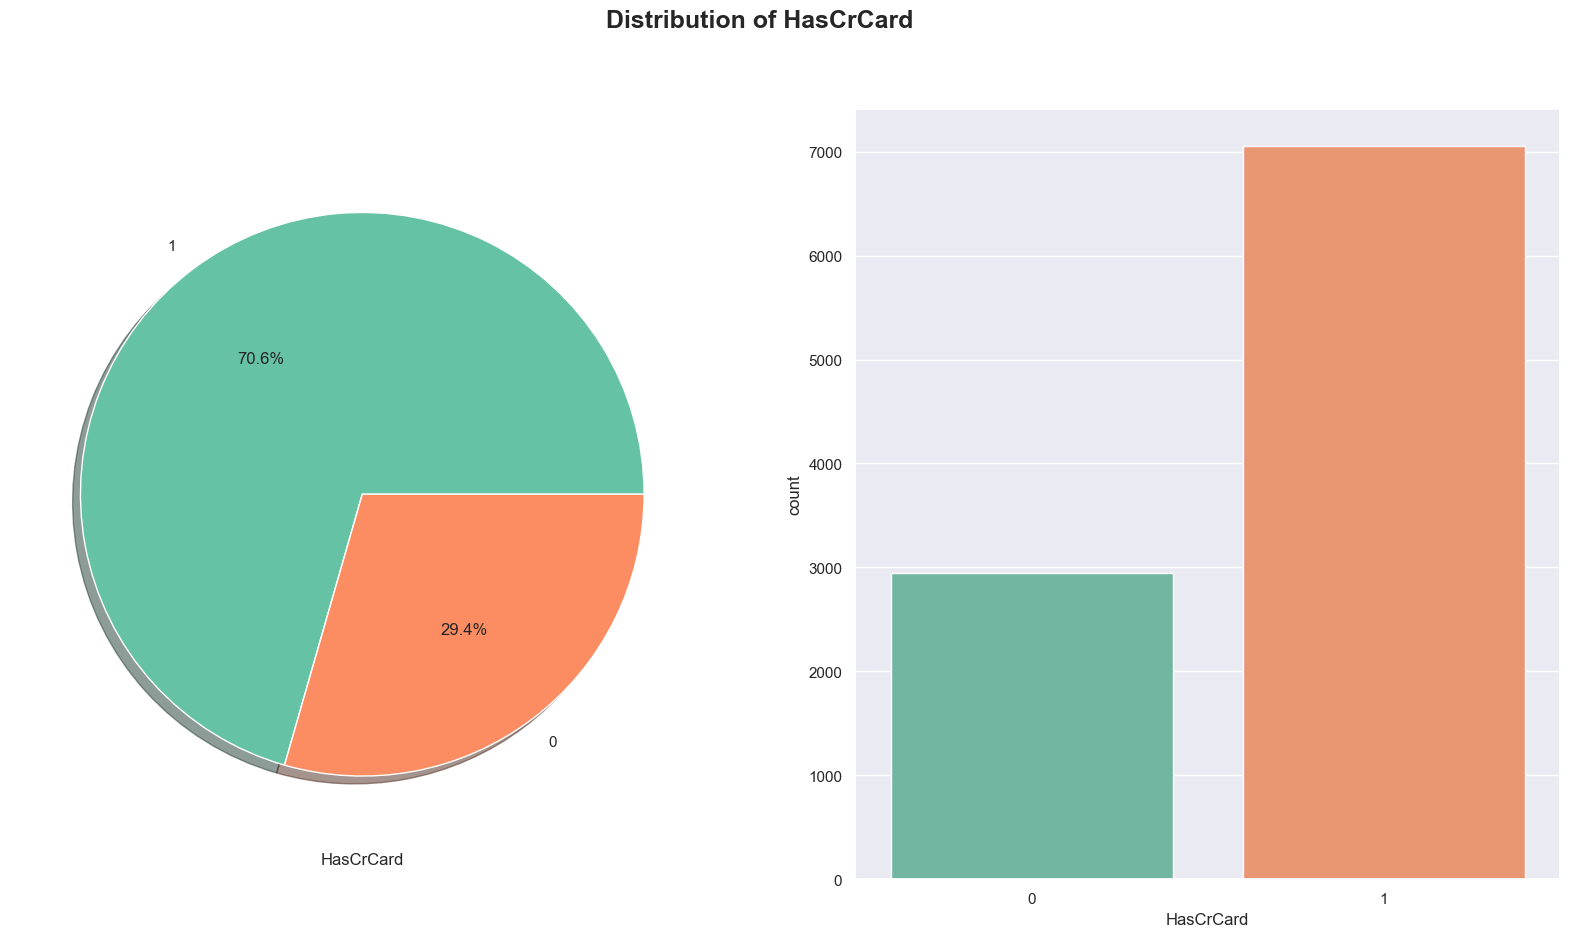

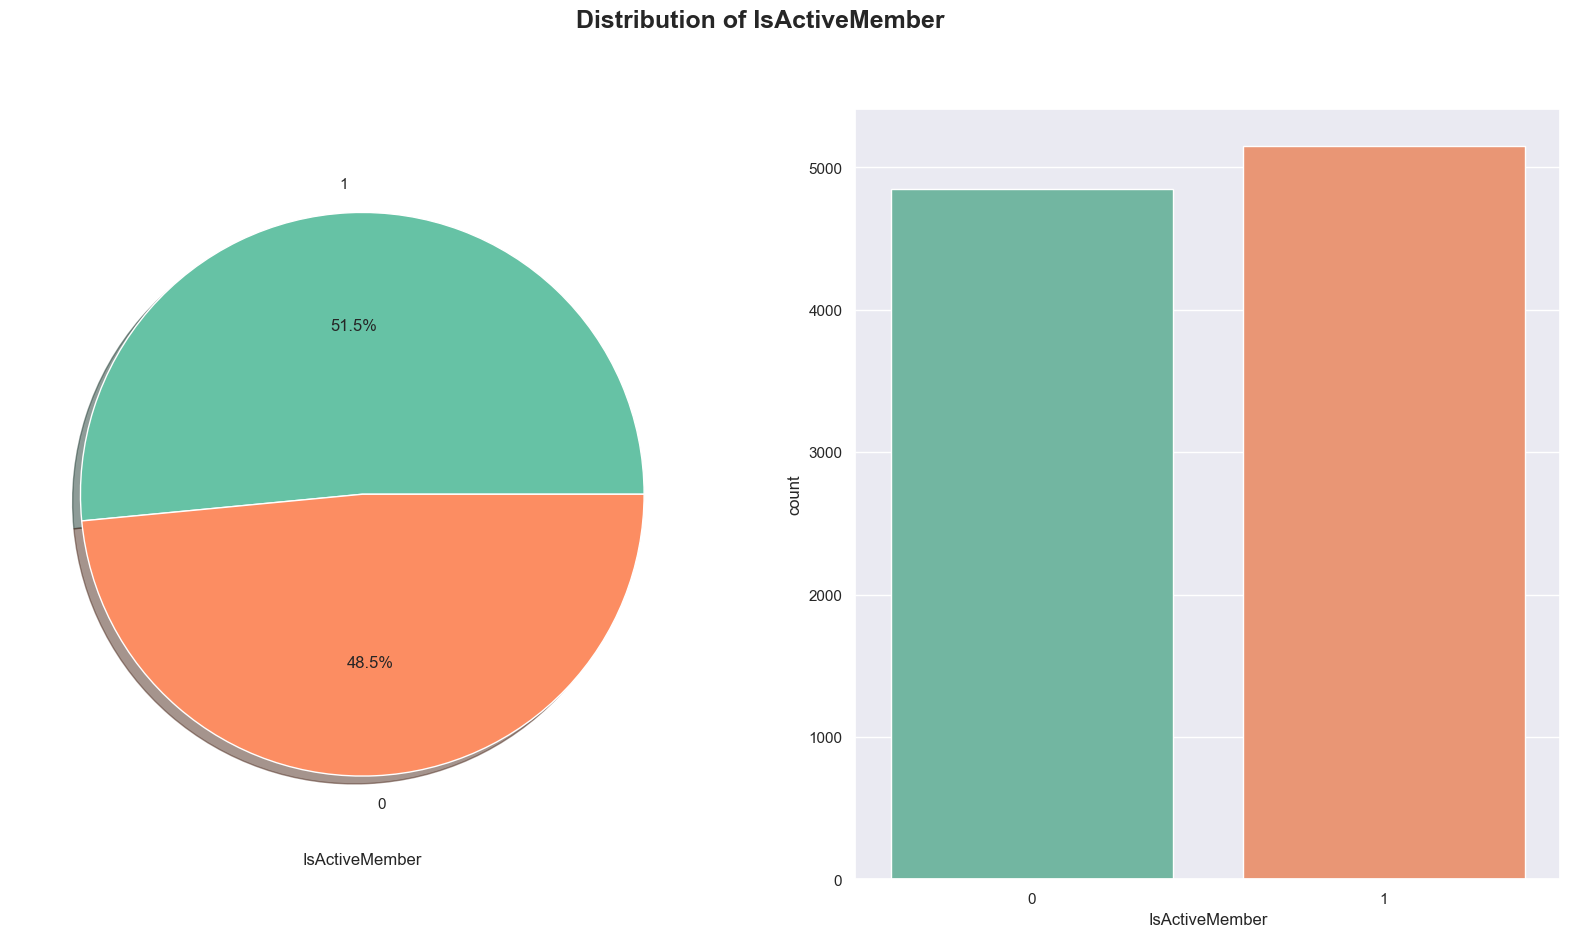

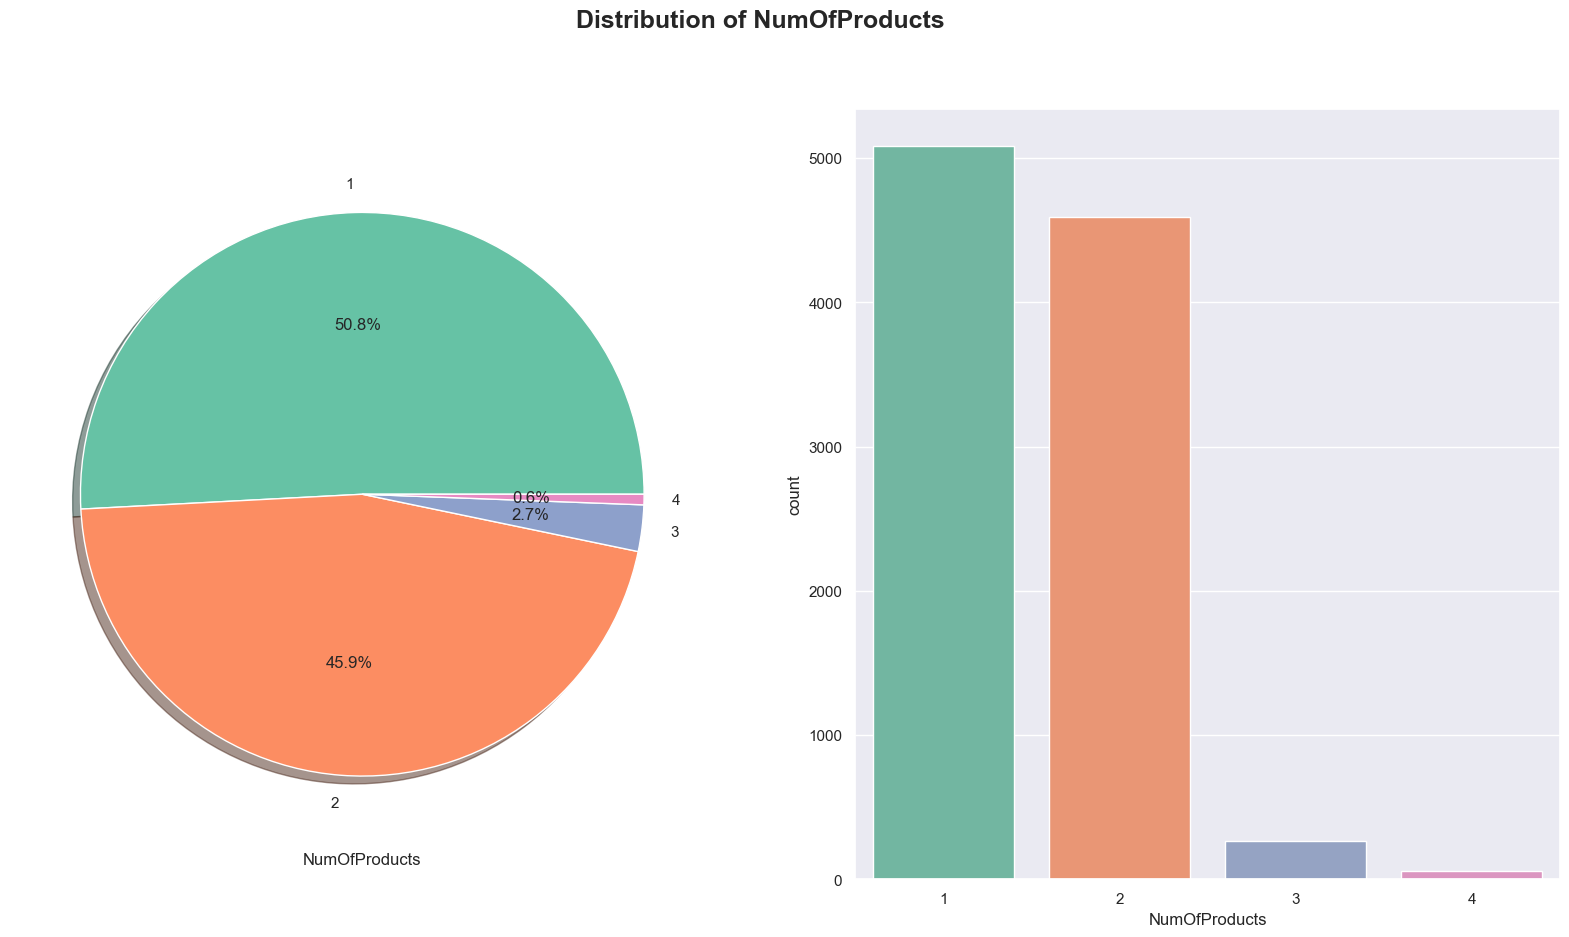

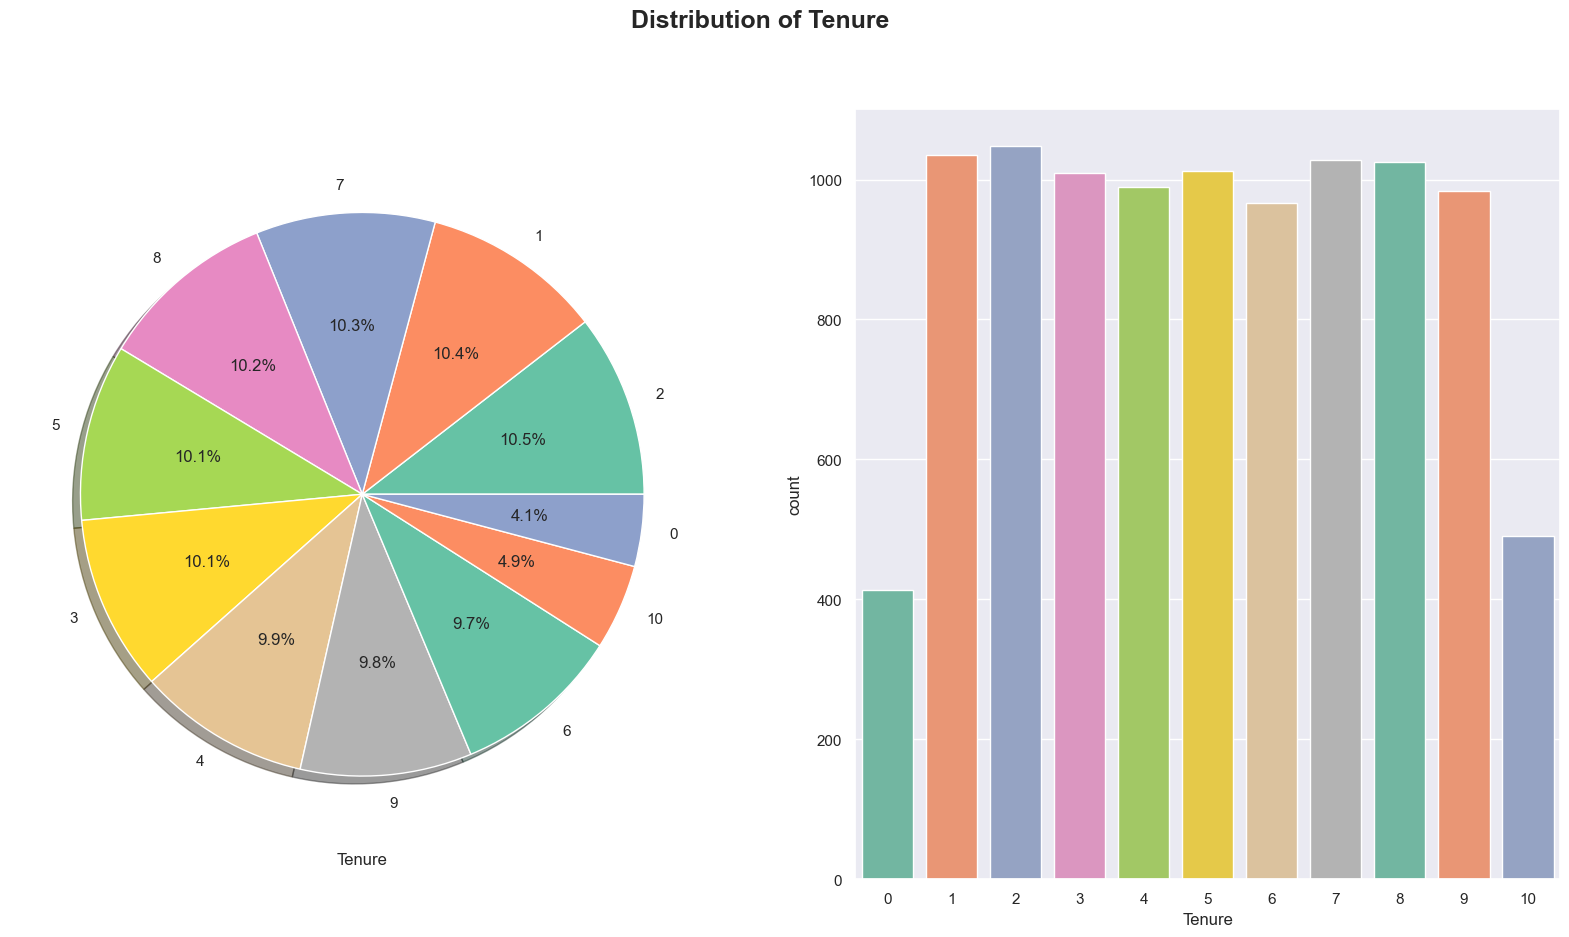

In [40]:
### Graphical Exploratory Data Analysis (Discrete/Binary Numerical Feature Distributions)
column_names = ["HasCrCard", "IsActiveMember", "NumOfProducts", "Tenure"]
for column_name in column_names:
    plot_value_count_distribution(dataframe = df, column_name = column_name)

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        The difference in values for the discrete/binary numerical features is an important thing to be aware of. Especially in the case of the features <code>HasCrCard</code> and <code>NumOfProducts</code>.
    </p>
</div>

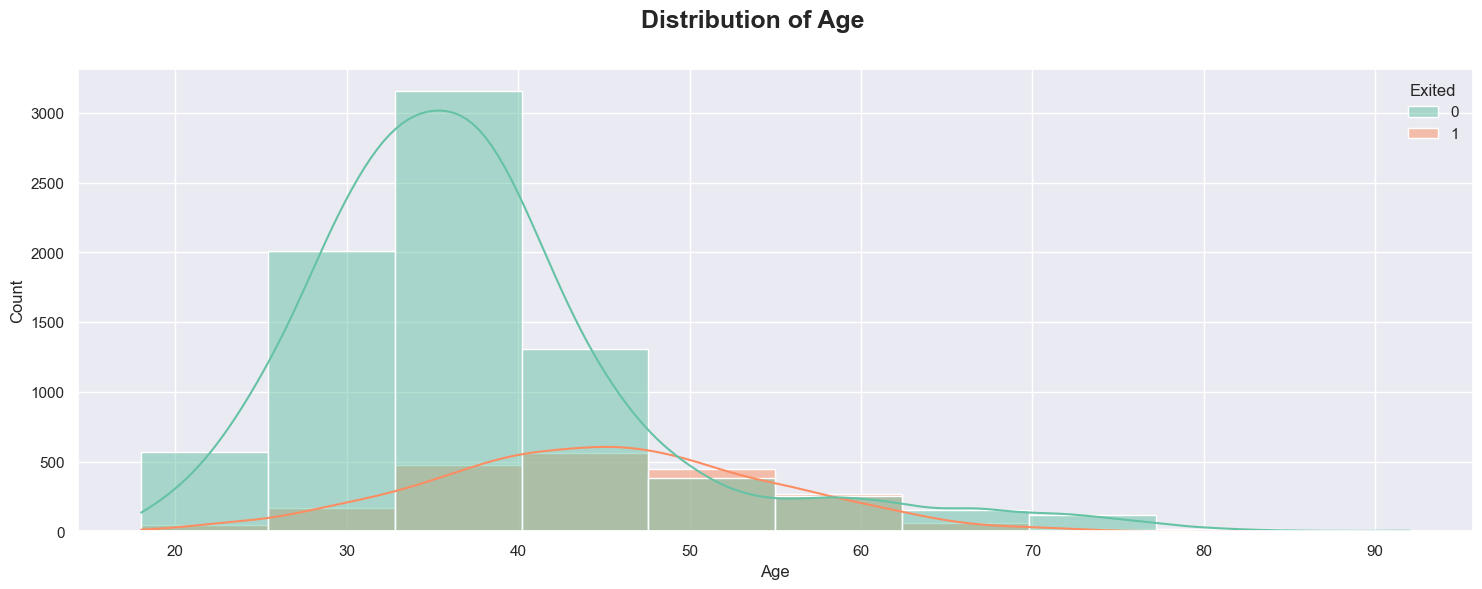

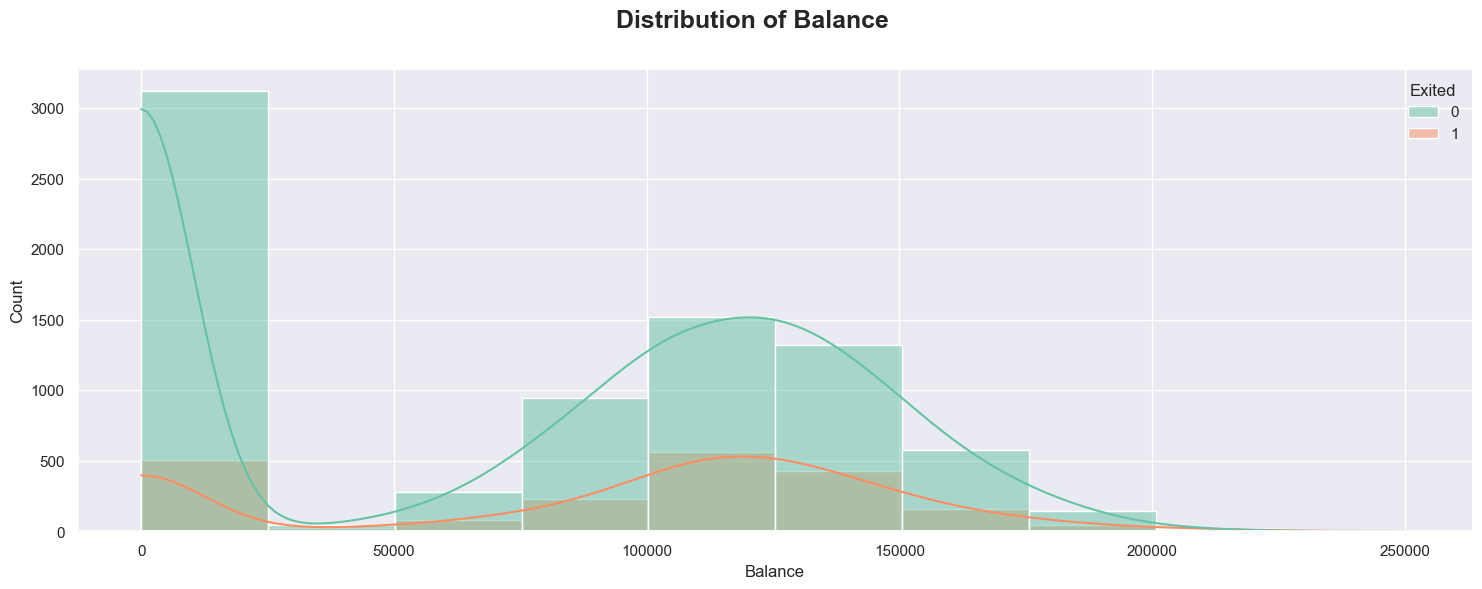

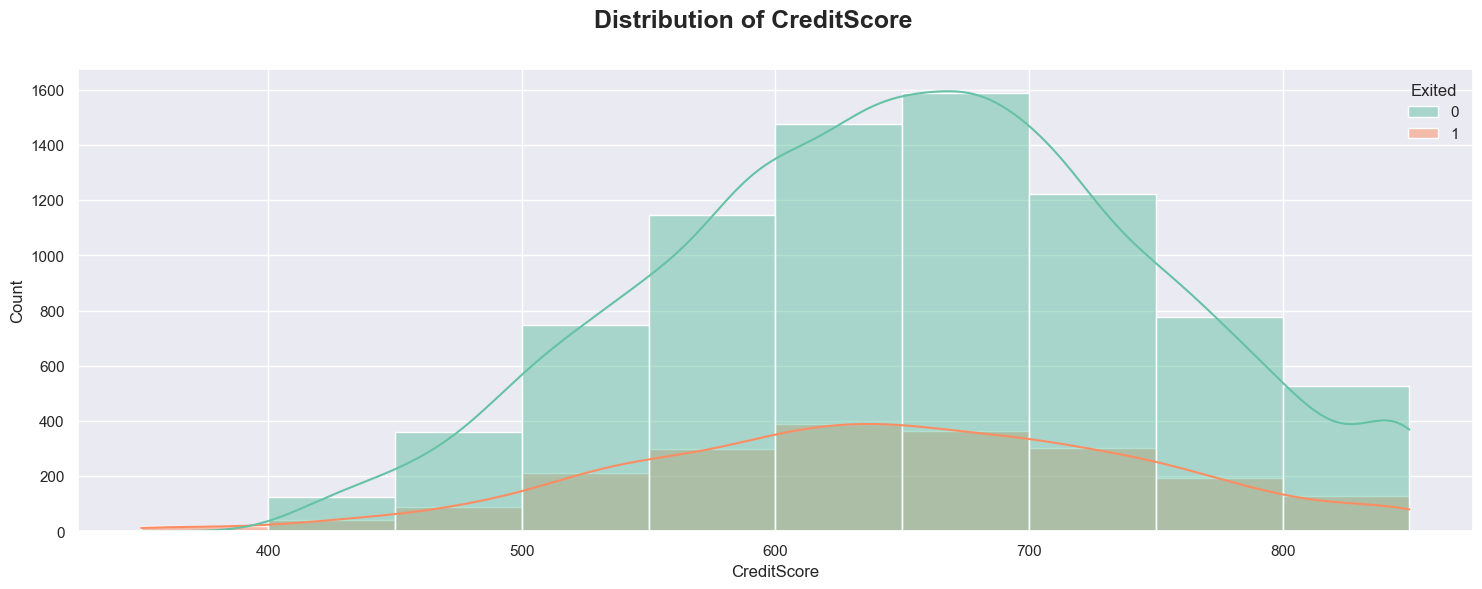

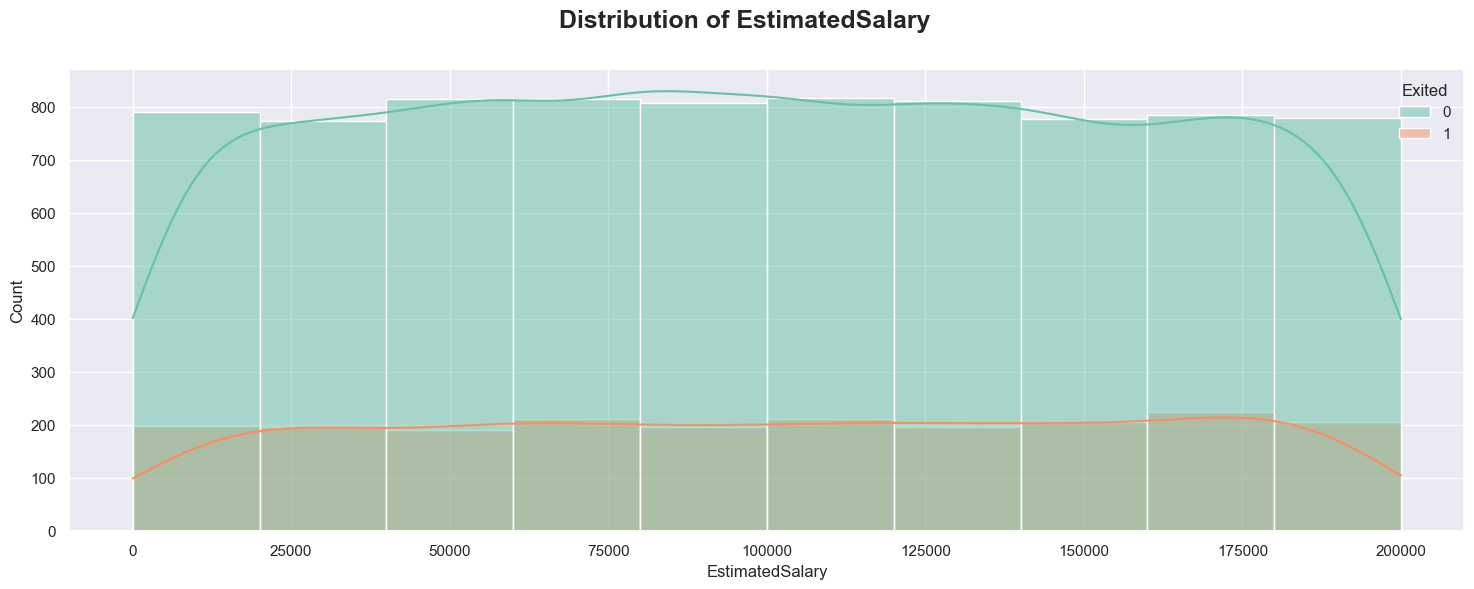

In [41]:
### Graphical Exploratory Data Analysis (Continuous Numerical Feature Distributions)
column_names = ["Age", "Balance", "CreditScore", "EstimatedSalary"]
for column_name in column_names:
    plot_continuous_distribution(dataframe = df, column_name = column_name, target_column = "Exited")

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        With the exception of <code>Age</code>, the distribution of customers who exited, closely matches in shape the distribution of customers who did not exit. Additionally, with the exception of <code>EstimatedSalary</code>, the features have rather skewed distributions.
    </p>
</div>

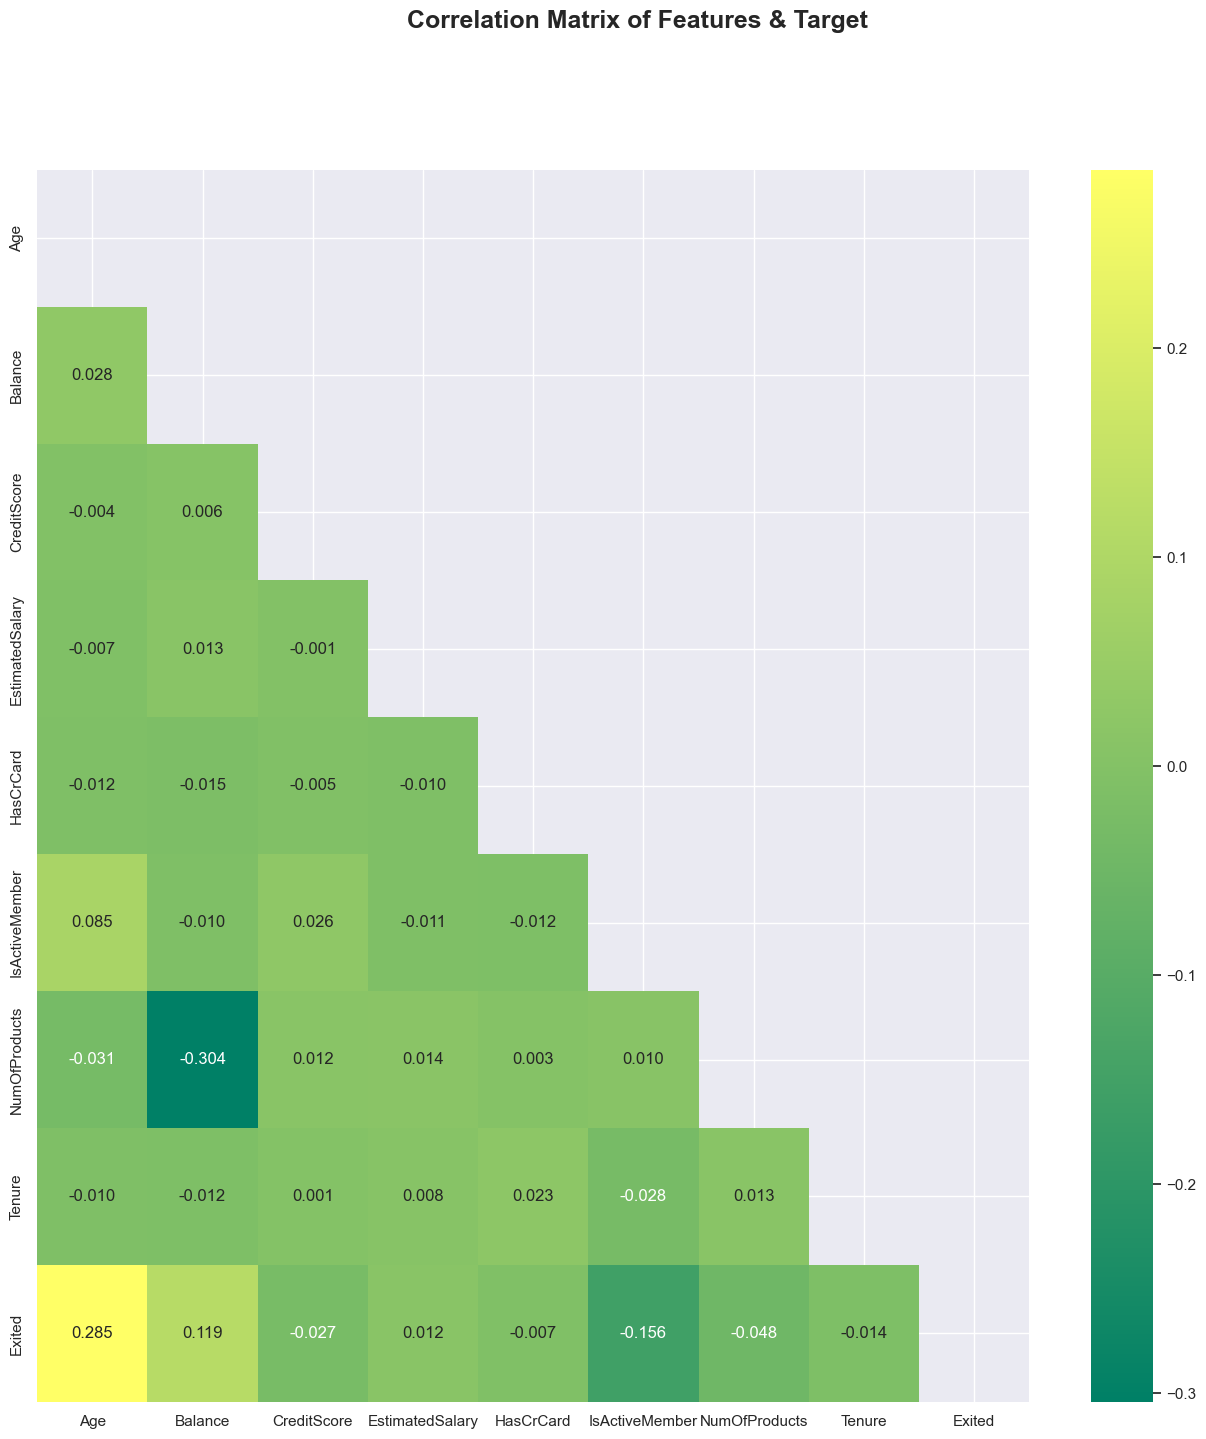

In [42]:
### Graphical Exploratory Data Analysis (Correlation Matrix)
column_names = ["Age", "Balance", "CreditScore", "EstimatedSalary", "HasCrCard", "IsActiveMember", "NumOfProducts", "Tenure", "Exited"]
plot_correlation_matrix(dataframe = df, column_list = column_names)

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        The correlations between a lot of the columns is about evenly split between negative and positive correlations. For the columns that have negative correlations, it is generally very small, with the exception of the <b>-0.304</b> correlation between <code>Balance</code> and <code>NumOfProducts</code>.
    </p>
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        The positive correlations have a bit more variance, with the most positive correlation <b>0.285</b> being between <code>Age</code> and <code>Exited</code>.
    </p>
</div>

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1.2rem; color: #000000"><b>Data Pre-Processing:</b></p>
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        This section focuses on pre-processing the data for use in training a machine learning model.
    </p>
</div>

In [43]:
### Helpers for Data Pre-Processing
## Encoding Data
# One-Hot Encoding
def one_hot_encode(dataframe: pd.DataFrame, column_list: list[str]) -> pd.DataFrame:
    # Creating the Encodings
    dataframe = pd.get_dummies(data = dataframe, columns = column_list, dtype = int)
    return dataframe

In [44]:
### Preparing Data for Modeling
## Data Normalization
# Creating Copy of Original DataFrame
preprocessed_df = df.copy()

# Dropping Unused Columns
column_names = ["RowNumber", "CustomerId", "Surname"]
preprocessed_df.drop(columns = column_names, axis = 1, inplace = True)

# Encoding Categorical Features
column_names = ["Gender", "Geography"]
preprocessed_df = one_hot_encode(dataframe = preprocessed_df, column_list = column_names)

## Splitting Data
# Identifying Feature Columns
column_names = preprocessed_df.columns.to_list()
column_names.remove("Exited")

# Splitting Data Into Features & Target
FEATURES, TARGET = preprocessed_df[column_names], preprocessed_df["Exited"]

# Creating Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    FEATURES, TARGET,
    test_size = .2,
    random_state = 100,
    shuffle = True,
    stratify = TARGET
)

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        In order to normalize the data, categorical features like <code>Gender</code> and <code>Geography</code> need to be one-hot encoded for the model to better utilize the data points stored in those columns.
    </p>
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        Additionally, as this dataset is not pre-split, it needs to be split into training and testing datasets to allow for model validation. In order to ensure reasonable representation of all data points, the split data has been shuffled for randomness, and stratified according to the target column.
    </p>
</div>

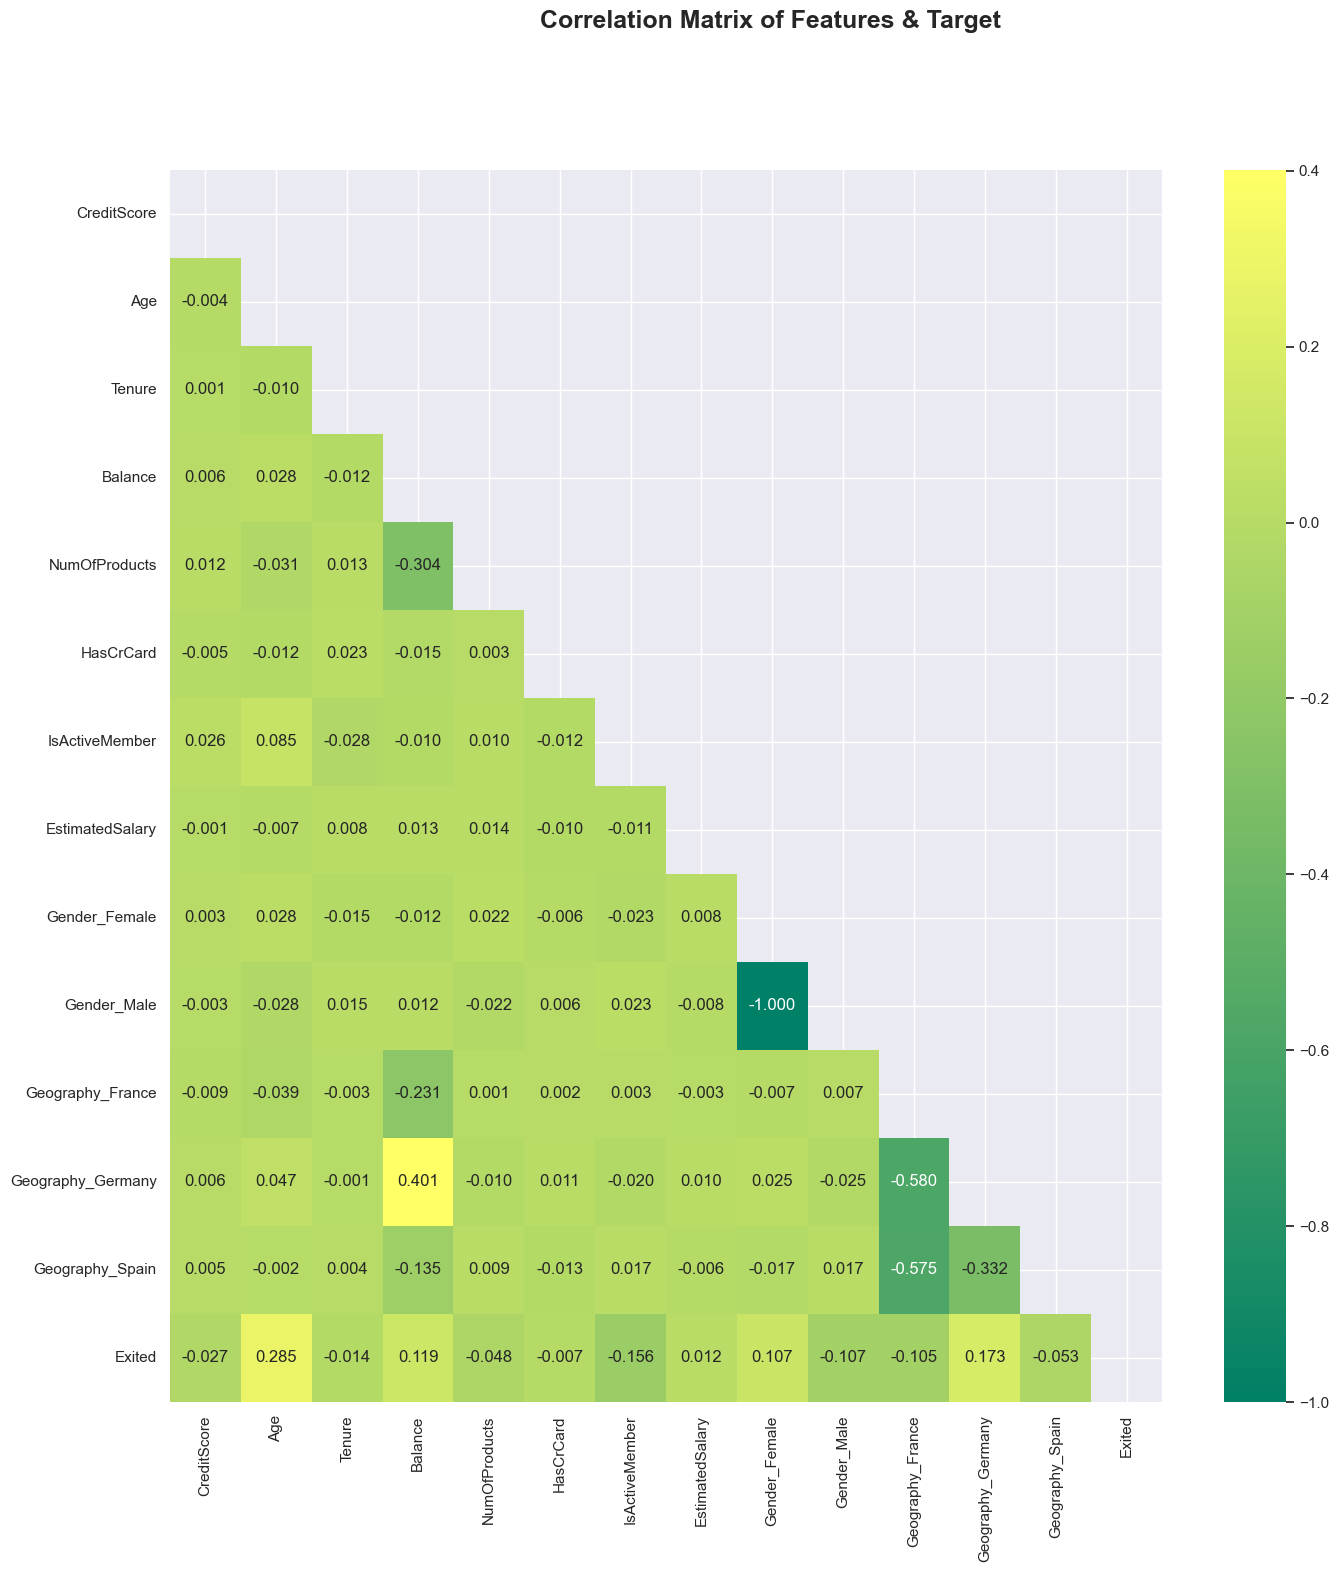

In [45]:
### Graphical Exploratory Data Analysis (Correlation Matrix)
## Viewing Pre-Processed Correlation Matrix
column_names.append("Exited")
plot_correlation_matrix(dataframe = preprocessed_df, column_list = column_names)

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        Before proceeding with the machine learning portion of this notebook, it is a good idea to revisit the correlation matrix with the new encodings.
    </p>
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        With the newly encoded columns, it is possible to see new details. Such as the correlations based on <code>Gender</code> and <code>Geography</code>. For example, it is interesting to see that there is a high (<b>0.401</b>) correlation between <code>Balance</code> and <code>Geography_Germany</code>, given that about 50% of customers are based in France, compared to the approximately 25% that are based in Germany.
    </p>
</div>

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1.2rem; color: #000000"><b>Machine Learning:</b></p>
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        This section focuses on using the <code>XGBoost</code> package to train and test a model that can later be exported for use in other applications.
    </p>
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        The use of <code>XGBoost</code> is due to its scalability and efficiency. It simplifies the model selection process by implicitly handling steps such as cross-validation, tree pruning, etc. Additionally, it can be trained relatively quickly due to its parallelization/concurrency features.
    </p>
</div>

In [87]:
### Helpers for Machine Learning
## Visualizations
# Plotting Confusion Matrix
def plot_confusion_matrix(true: np.typing.ArrayLike, predictions: np.typing.ArrayLike) -> None:
    # Creating Confusion Matrix
    conf_matrix = confusion_matrix(y_true = true, y_pred = predictions)

    # Defining Canvas Style
    configure_canvas_styles()

    # Creating Canvas for Display
    display = ConfusionMatrixDisplay(
        confusion_matrix = conf_matrix,
        display_labels = ["Stayed", "Exited"]
    )

    # Plotting Confusion Matrix
    display.plot(cmap = "YlGnBu")

    # Displaying Canvas
    plt.show()

## Model Evaluation
# Getting Percentage Difference
def get_percentage_difference(a: int | float, b: int | float) -> int | float:
    return (abs(a - b) / ((a + b) / 2)) * 100

# Getting Percentage Change
def get_percentage_change(a: int | float, b: int | float) -> int | float:
    return ((b - a) / abs(a)) * 100

In [47]:
### Baseline Classifier
## Model Training
# Creating the Model
base = xgb.XGBClassifier(
    objective = "binary:logistic",
    seed = 100
)

# Fitting the Model
base.fit(
    X_train, y_train,
    early_stopping_rounds = 10,
    eval_metric = "auc",
    eval_set = [(X_test, y_test)],
    verbose = False
)

## Model Evaluation
# Viewing Base Model Score
base.score(X_test, y_test)

0.8535

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        Before tuning the model's parameters (hyperparameter tuning), it is a good idea to review the model's baseline performance. 
    </p>
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        Since the target column contains binary values, and this is classification problem, the learning task parameter <code>objective</code> is set to <code>binary:logistic</code>. This setting outputs a probability without transforming the data. The <code>seed</code> parameter ensures that the classifier can be reliably reproduced.
    </p>
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        The use of the parameter <code>early_stopping_rounds</code> is to minimize loss. It stops the training process when the loss on the validation data starts increasing. The evaluation metric for this model is <b>auc</b> or <b>Area Under Curve</b> due to the disproportionate representation in the target column. This metric is one of the best options when working with heavily skewed datasets.
    </p>
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        Without any tuning, the model is able to predict correctly <b>85%</b> of the time whether a customer will exit the bank.
    </p>
</div>

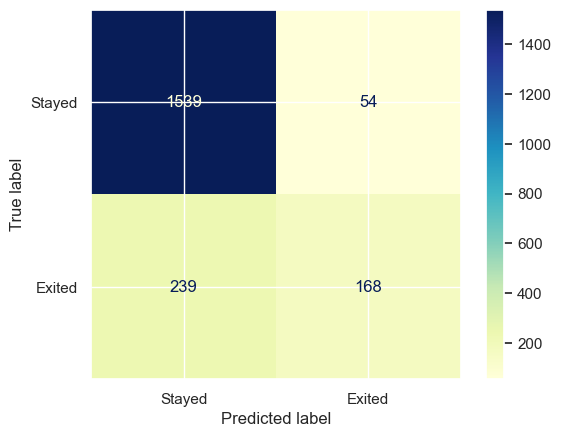

In [64]:
### Graphical Exploratory Data Analysis (Confusion Matrix)
plot_confusion_matrix(true = y_test, predictions = base.predict(X_test))

In [73]:
### Evaluating Model Outcomes
## Checking for False Values
# Difference Between True (Exit) and False (Stayed)
get_percentage_difference(168, 239)

34.88943488943489

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        While the performance of the model is decent. The confusion matrix shows that the model inaccurately predicted that customers stayed when they exited, more than accurately predicting customers that exited who did exit by a difference of <b>34%</b>.
    </p>
</div>

In [75]:
### Model Optimization
## Initializing Variables
# Defining Parameter Grid
parameter_grid = [
    {
        "objective": ["binary:logistic"],
        "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        "colsample_bytree": [0.2, 0.4, 0.6, 0.8],
        "max_depth": [1, 3, 5, 7],
        "gamma": [0.0, 0.25, 0.5, 0.75, 1.0],
        "reg_lambda": [0, 1, 5, 10],
        "scale_pos_weight": [1, 3, 5, 7]
    }
]

## Classifier Tuning
# Creating New (Unfitted) Base Classifier
base = xgb.XGBClassifier(seed = 100)

# Using GridSearch to Find Optimal Classifier
grid_search = GridSearchCV(
    estimator = base,
    param_grid = parameter_grid,
    scoring = "roc_auc",
    return_train_score = True,
    verbose = 10,
    n_jobs = 10,
    cv = 5
)

# Fitting the GridSearch
grid_search.fit(
    X = X_train,
    y = y_train,
    eval_metric = "auc",
    eval_set = [(X_test, y_test)],
    early_stopping_rounds = 10,
    verbose = False,
)

# Viewing Optimal Parameters
grid_search.best_params_

Fitting 5 folds for each of 11520 candidates, totalling 57600 fits


{'colsample_bytree': 0.8,
 'gamma': 0.25,
 'max_depth': 3,
 'objective': 'binary:logistic',
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.9}

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        The use of <code>GridSearchCV</code> allows for more robust hyperparameter tuning, as it automatically tests all combinations within the given parameter grid. The criteria for the parameters chosen is based off of how conservative they can make the model (in an effort to lower the amount of False Negatives), and how well suited they are for datasets that are skewed.
    </p>
</div>

In [79]:
### Model Comparison & Evaluation
## Refitting Base Model
# Fitting Model
base.fit(
    X_train, y_train,
    early_stopping_rounds = 10, 
    eval_metric = "auc",
    eval_set = [(X_test, y_test)],
    verbose = False
)

## Calculating Percentage Change In Model Score
# Viewing Percentage Change
get_percentage_change(base.score(X_test, y_test), grid_search.best_score_)

1.4558169891650148

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        After optimizing the model's parameters, the model improved by <b>1.45%</b>.
    </p>
</div>

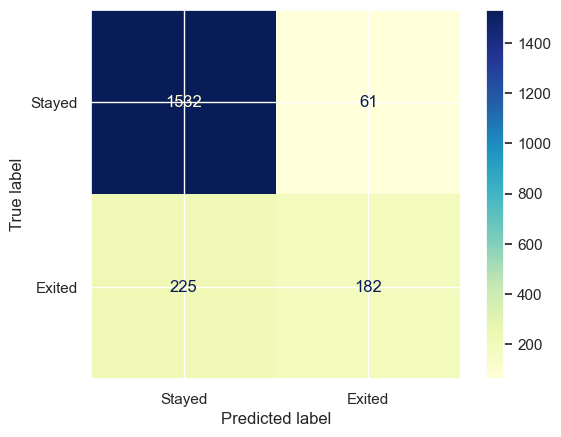

In [80]:
### Graphical Exploratory Data Analysis (Confusion Matrix)
plot_confusion_matrix(true = y_test, predictions = grid_search.best_estimator_.predict(X_test))

In [86]:
### Evaluating Model Outcomes
## Checking for False Values
# Difference Between True (Exit) and False (Stayed)
print(f"Optimized Model False Negative % Difference: {get_percentage_difference(182, 225)}")

## Comparing to Base Model
# Change Between Base & Optimized Model
print(f"% Change in False Negatives Between Base & Optimized Model: {get_percentage_change(get_percentage_difference(168, 239), get_percentage_difference(182, 225))}")

Optimized Model False Negative % Difference: 21.13022113022113
% Change in False Negatives Between Base & Optimized Model: -39.436619718309856


<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        The <b style="color:#a1cd44">1.45%</b> increase in the model's performance has lead to a <b style="color:#cd5444"> -39%</b> change in the amount of False Negatives predicted by the model. A considerable improvement. 
    </p>
</div>

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1.2rem; color: #000000"><b>Serializing & Exporting:</b></p>
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        This section focuses on serializing and exporting the model for use in other applications.
    </p>
</div>

In [111]:
### Helpers for Exporting the Model
## Variables
# Files & Directories
MODEL_DIRECTORY = os.path.join("..", "models")
MODEL_FILE = "model.json"

## Functions
# Export Model
def export_model(model: xgb.XGBClassifier, file: str = MODEL_FILE) -> None:
    try:
        if file != MODEL_FILE:
            model.save_model(os.path.join(MODEL_DIRECTORY, file))
        else:
            model.save_model(os.path.join(MODEL_DIRECTORY, MODEL_FILE))
    except Exception as error:
        print(f"{error.__class__.__name__}: {error}")

In [112]:
### Exporting Models
## Setup
# Defining Models for Export
models = [
    {"model": base, "file": "base_model.json"},
    {"model": grid_search.best_estimator_, "file": "optimized_model.json"}
]

## Export
# Iterating Through Model List
for model in models:
    export_model(model = model["model"], file = model["file"])

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1.2rem; color: #000000"><b>Conclusion:</b></p>
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        This section focuses on concluding thoughts related to the contents of this notebook.
    </p>
</div>

<div style="background-color: #f0f0f0; box-shadow: 10px 5px; padding: 20px; border-radius: 15px; margin: auto; width: 100vw">
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        Given the scale of the dataset (about 10000 rows), the 80/20 skew in the target column (stayed/exited), and the limitation of keeping the model training performant with access only to a CPU, an <b>85%+</b> success rate is very fair.
    </p>
    <p style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
        Potential improvements to the model could be: 
        <ul style="font-family: 'JetBrains Mono', sans-serif; font-size: 1rem; color: #333333;">
            <li>Gathering more data to train the model on</li>
            <li>Enabling GPU support, thus allowing for new parameter options and additional parameter grid configurations</li>
            <li>Trying out other sampling methods, such as SMOTE, to balance the skew</li>
        </ul>
    </p>
</div>